In [2]:
import pandas as pd
import numpy as np

# Load from URL or local file
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv"
df = pd.read_csv(url)

# Drop non-numeric and missing values for simplicitym
df = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']].dropna()

# Convert all to float for PC
data = df
columns = df.columns.tolist()


In [3]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8,307.0,130.0,3504,12.0
1,15.0,8,350.0,165.0,3693,11.5
2,18.0,8,318.0,150.0,3436,11.0
3,16.0,8,304.0,150.0,3433,12.0
4,17.0,8,302.0,140.0,3449,10.5
...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6
394,44.0,4,97.0,52.0,2130,24.6
395,32.0,4,135.0,84.0,2295,11.6
396,28.0,4,120.0,79.0,2625,18.6


C:\Users\turningpointKS\anaconda3\envs\causal-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Depth=3, working on node 5: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 189.20it/s]


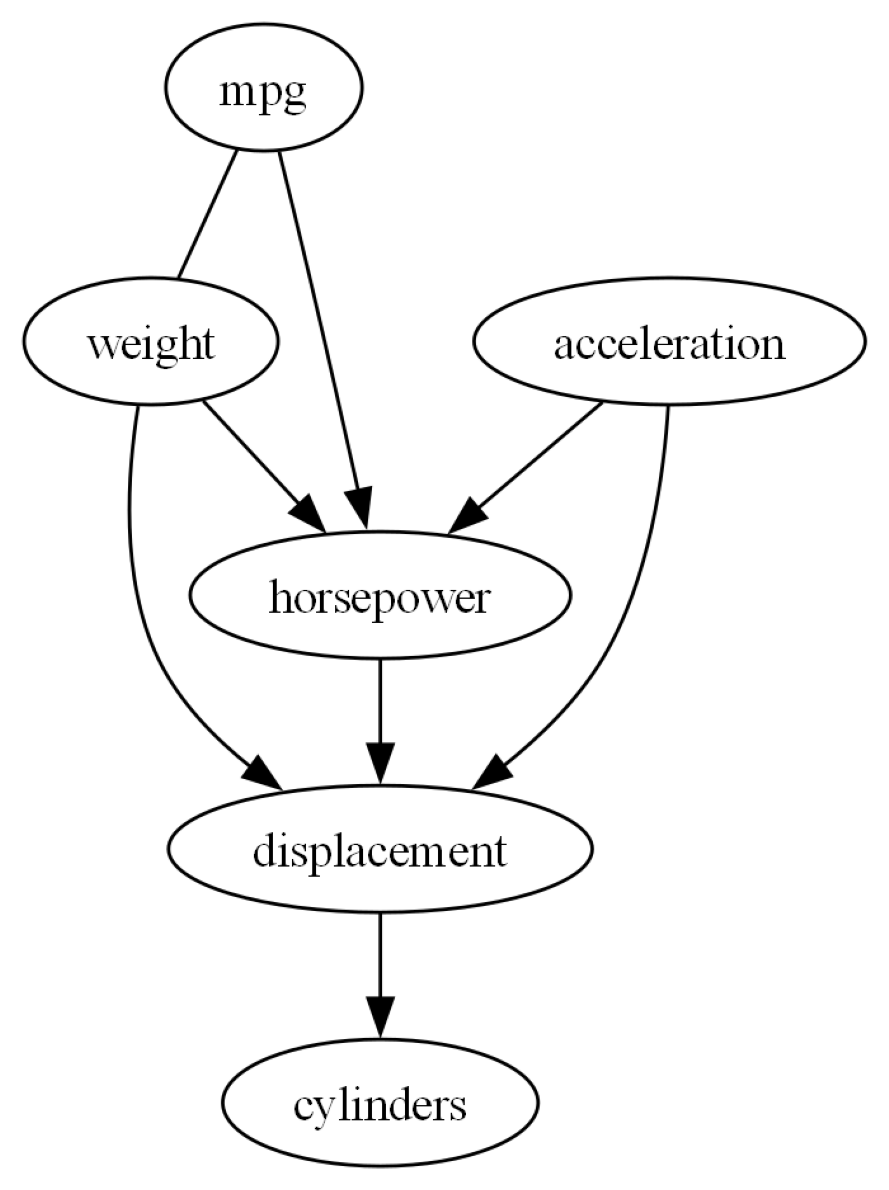

In [4]:
import pandas as pd
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
import matplotlib.pyplot as plt

# Run PC algorithm
cg = pc(data.values, alpha=0.05, indep_test_func=fisherz, labels=columns)

# Draw the graph (uses pydot/graphviz)
cg.draw_pydot_graph(labels=columns)

# Show the Matplotlib figure
plt.show()


In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv")

# Keep only relevant numeric columns and drop missing values
df = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']].dropna()

# Discretize continuous columns (optional but recommended for pgmpy)
# We'll bin them into categories (low, medium, high)
for col in df.columns:
    df[col] = pd.qcut(df[col], q=3, labels=["low", "medium", "high"])

edges = [
    ("cylinders", "displacement"),
    ("displacement", "horsepower"),
    ("horsepower", "weight"),
    ("horsepower", "acceleration"),
    ("horsepower", "mpg"),
    ("displacement", "acceleration"),
    ("displacement", "weight"),
    ("weight", "mpg"),
]

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator

model = DiscreteBayesianNetwork(edges)
model.fit(df, estimator=BayesianEstimator, prior_type='BDeu')  # BDeu is Bayesian smoothing

for cpd in model.get_cpds():
    print(f"\nCPD of {cpd.variable}:\n", cpd)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'mpg': 'O', 'cylinders': 'O', 'displacement': 'O', 'horsepower': 'O', 'weight': 'O', 'acceleration': 'O'}



CPD of cylinders:
 +-------------------+----------+
| cylinders(high)   | 0.263644 |
+-------------------+----------+
| cylinders(low)    | 0.515533 |
+-------------------+----------+
| cylinders(medium) | 0.220823 |
+-------------------+----------+

CPD of displacement:
 +----------------------+----------------------+-----------------------+-----------------------+
| cylinders            | cylinders(high)      | cylinders(low)        | cylinders(medium)     |
+----------------------+----------------------+-----------------------+-----------------------+
| displacement(high)   | 0.9893842887473461   | 0.0027144408251900116 | 0.26869455006337134   |
+----------------------+----------------------+-----------------------+-----------------------+
| displacement(low)    | 0.005307855626326964 | 0.6623235613463627    | 0.0063371356147021544 |
+----------------------+----------------------+-----------------------+-----------------------+
| displacement(medium) | 0.005307855626326964 | 0.3349

In [6]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

# Example: What's the probability distribution over mpg given weight is high and acceleration is low?
query = infer.query(variables=['mpg'], evidence={'weight': 'high', 'acceleration': 'low'})
print(query)


+-------------+------------+
| mpg         |   phi(mpg) |
+=============+============+
| mpg(high)   |     0.0023 |
+-------------+------------+
| mpg(low)    |     0.9205 |
+-------------+------------+
| mpg(medium) |     0.0771 |
+-------------+------------+


In [11]:
from pgmpy.factors.discrete import TabularCPD
import copy
from pgmpy.inference import VariableElimination

def do_intervention(model, intervention_var, intervention_value, query_var):
    intervened_model = copy.deepcopy(model)

    # Remove all parents of the intervention variable
    for parent in intervened_model.get_parents(intervention_var):
        intervened_model.remove_edge(parent, intervention_var)

    # Get state names and fix probability for intervention_value
    state_names = model.get_cpds(intervention_var).state_names[intervention_var]
    fixed_probs = [1.0 if s == intervention_value else 0.0 for s in state_names]

    # ✅ FIXED: shape now (len(states), 1)
    new_cpd = TabularCPD(
        variable=intervention_var,
        variable_card=len(state_names),
        values=[[p] for p in fixed_probs],
        state_names={intervention_var: state_names}
    )

    intervened_model.remove_cpds(intervention_var)
    intervened_model.add_cpds(new_cpd)

    # Inference
    infer = VariableElimination(intervened_model)
    result = infer.query(variables=[query_var])

    return result


In [13]:
result = do_intervention(model, intervention_var='displacement', intervention_value='low', query_var='cylinders')
print(result)

+-------------------+------------------+
| cylinders         |   phi(cylinders) |
+===================+==================+
| cylinders(high)   |           0.2636 |
+-------------------+------------------+
| cylinders(low)    |           0.5155 |
+-------------------+------------------+
| cylinders(medium) |           0.2208 |
+-------------------+------------------+
